In [1]:
import os
import glob

import ants

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import nibabel as nib

import SimpleITK as sitk


from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
#ROOT_DIR = "/home/fehrdelt/bettik/"
ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

In [3]:
soop_flair_final_output_folder_registered = ROOT_DIR+"datasets/final_soop_dataset_small/flair_registered/"

atlas_image_path = ROOT_DIR+"datasets/ArterialAtlas.nii"

registered_atlases_folder = ROOT_DIR+"datasets/final_soop_dataset_small/registered_atlases/"


### register the atlas to a template so it has roughly the same size etc

In [ ]:
atlas_image = nib.load(atlas_image_path)


atlas_data = atlas_image.get_fdata()

for i in range(atlas_data.shape[0]):
    for j in range(atlas_data.shape[1]):
        for k in range(atlas_data.shape[2]):
            if atlas_data[i,j,k] > 0.1:
                atlas_data[i,j,k] = 80.0

resized_atlas_image = nib.Nifti1Image(atlas_data, affine=atlas_image.affine)
resized_atlas_path = ROOT_DIR+"datasets/ArterialAtlas_modif.nii"
nib.save(resized_atlas_image, resized_atlas_path)

In [ ]:
moving_image = ants.image_read(resized_atlas_path)
final_atlas = ants.image_read(ROOT_DIR+"datasets/ArterialAtlas.nii")
fixed_image = ants.image_read(ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/128_mni_icbm152_t1_skullstrip.nii.gz")

# Perform registration
registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='Similarity') # https://antspy.readthedocs.io/en/latest/registration.html types of transforms

registered_atlas = ants.apply_transforms(fixed=fixed_image, moving=final_atlas, transformlist=registration['fwdtransforms'], interpolator='nearestNeighbor')

# Save the registered image
ants.image_write(registered_atlas, os.path.join(ROOT_DIR+"datasets/", os.path.basename("final_atlas.nii.gz")))


### for every flair image, register elastically the template to the flair image and apply the same transform to the atlas

In [4]:
# Registration
def process_image_register(image_path, output_folder):
    
    final_output_path = os.path.join(output_folder, "registered_atlas_" + os.path.basename(image_path))
    if not os.path.exists(final_output_path):

        flair_image = ants.image_read(image_path)
        template_image = ants.image_read(ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/128_hist_match_to_dallas_FLAIR_mni_icbm152_t2.nii.gz")
        atlas_image = ants.image_read(ROOT_DIR+"datasets/registered_atlas_128.nii.gz")

        # Perform registration
        registration = ants.registration(fixed=flair_image, moving=template_image, type_of_transform='antsRegistrationSyNsr') # https://antspy.readthedocs.io/en/latest/registration.html types of transforms

        # Apply the same transform to the atlas
        warped_atlas = ants.apply_transforms(fixed=flair_image, moving=atlas_image, transformlist=registration['fwdtransforms'], interpolator='nearestNeighbor')

        
        ants.image_write(warped_atlas, final_output_path)


image_paths = glob.glob(os.path.join(soop_flair_final_output_folder_registered, "*.nii.gz"))

with ProcessPoolExecutor(max_workers=64) as executor:
    futures = {executor.submit(process_image_register, path, registered_atlases_folder): path for path in image_paths}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
        _ = future.result()

Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1715/1715 [41:53<00:00,  1.47s/it]


### Visualize the registered atlases

In [8]:
print(glob.glob(registered_atlases_folder+"*.nii.gz")[0])

/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/final_soop_dataset_small/registered_atlases/registered_atlas_sub-162_FLAIR.nii.gz


In [27]:
def display_middle_slice(folder_path, axe=2, nb_images=49, page_number=0, figsize=25, normalize_from_histogram_peak=False, hist_norm_target_value=200, max_display_value=30):
    # List all files in the folder
    files = sorted(os.listdir(folder_path)[nb_images*page_number:nb_images*(page_number+1)])

    # Filter out non-NIFTI files
    nifti_files = [f for f in files if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    # Create a figure to display all middle slices and their histograms
    rows = int(np.sqrt(nb_images))
    fig, axes = plt.subplots(rows, rows, figsize=(figsize, figsize+2))
    plt.tight_layout()

    for i, nifti_file in enumerate(nifti_files):
        # Load the NIFTI image
        img_path = os.path.join(folder_path, nifti_file)
        try:
            img = nib.load(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        data = img.get_fdata()

        # Get the middle slice along the specified axis
        if axe == 0:
            middle_slice = data.shape[0] // 2
            image_slice = data[middle_slice, :, :]
        elif axe == 1:
            middle_slice = data.shape[1] // 2
            image_slice = data[:, middle_slice, :]
        elif axe==2:
            middle_slice = data.shape[2] // 2
            image_slice = data[:, :, middle_slice]


        if normalize_from_histogram_peak:
            # Compute the histogram of the image slice
            hist, bins = np.histogram(image_slice.flatten(), bins=100, range=(np.max(image_slice)/5.0, np.max(image_slice)))

            # Find the value corresponding to the maximum of the histogram
            most_occurred_pixel_value = bins[np.argmax(hist)]

            image_slice = image_slice/most_occurred_pixel_value*hist_norm_target_value # scale it so the peak is always at hist_norm_target_value

        # Display the middle slice for the z-axis
        if normalize_from_histogram_peak:
            axes[i//rows, (i%rows)].imshow(image_slice, cmap='gray', vmin=0, vmax=max_display_value) # flair: vmax=450
        else:
            try:
                axes[i//rows, (i%rows)].imshow(image_slice, cmap='gray', vmin=0, vmax=np.max(image_slice))
            except:
                print("error displaying image:", nifti_file)
                print(f"shape: {data.shape}")
        
        #axes[i//rows, (i%rows)].set_title(f'{i+(page_number*nb_images)}')
        axes[i//rows, (i%rows)].set_title(f'{nifti_file.split('_')[2]}')
        axes[i//rows, (i%rows)].axis("off")

        axes[i//rows, (i%rows)].set_aspect('auto') # Set the aspect ratio to auto to match the imshow plot
        axes[i//rows, (i%rows)].set_box_aspect(1)  # Set the aspect ratio of the histogram subplot


    # Set the title of the figure
    fig.suptitle(f'Middle slices and histograms for all NIFTI files, axe={axe}, page {page_number}', fontsize=16)
    
    # Show the plot
    plt.show()


In [56]:
failed_atlas_registrations = ["sub-185", "sub_1303", "sub-199", "sub-984", "sub-1138", "sub-767", "sub-1251", "sub-855",
                              "sub-1660", "sub-512", "sub-1698", "sub-617", "sub-1119", "sub-1183", "sub-1558", "sub-279",
                              "sub-846", "sub-1610", "sub-1261", "sub-1308", "sub-1717", "sub-7", "sub-1041", "sub-343",
                              "sub-989", "sub-605", "sub-234", "sub-1203", "sub-1491", "sub-949", "sub-1727"]


csv_path = os.path.join(ROOT_DIR, "StrokeUADiag", "exclude_failed_registration.csv")

with open(csv_path, "w") as f:
    f.write("\n".join(failed_atlas_registrations))


In [57]:
print(len(failed_atlas_registrations))

31


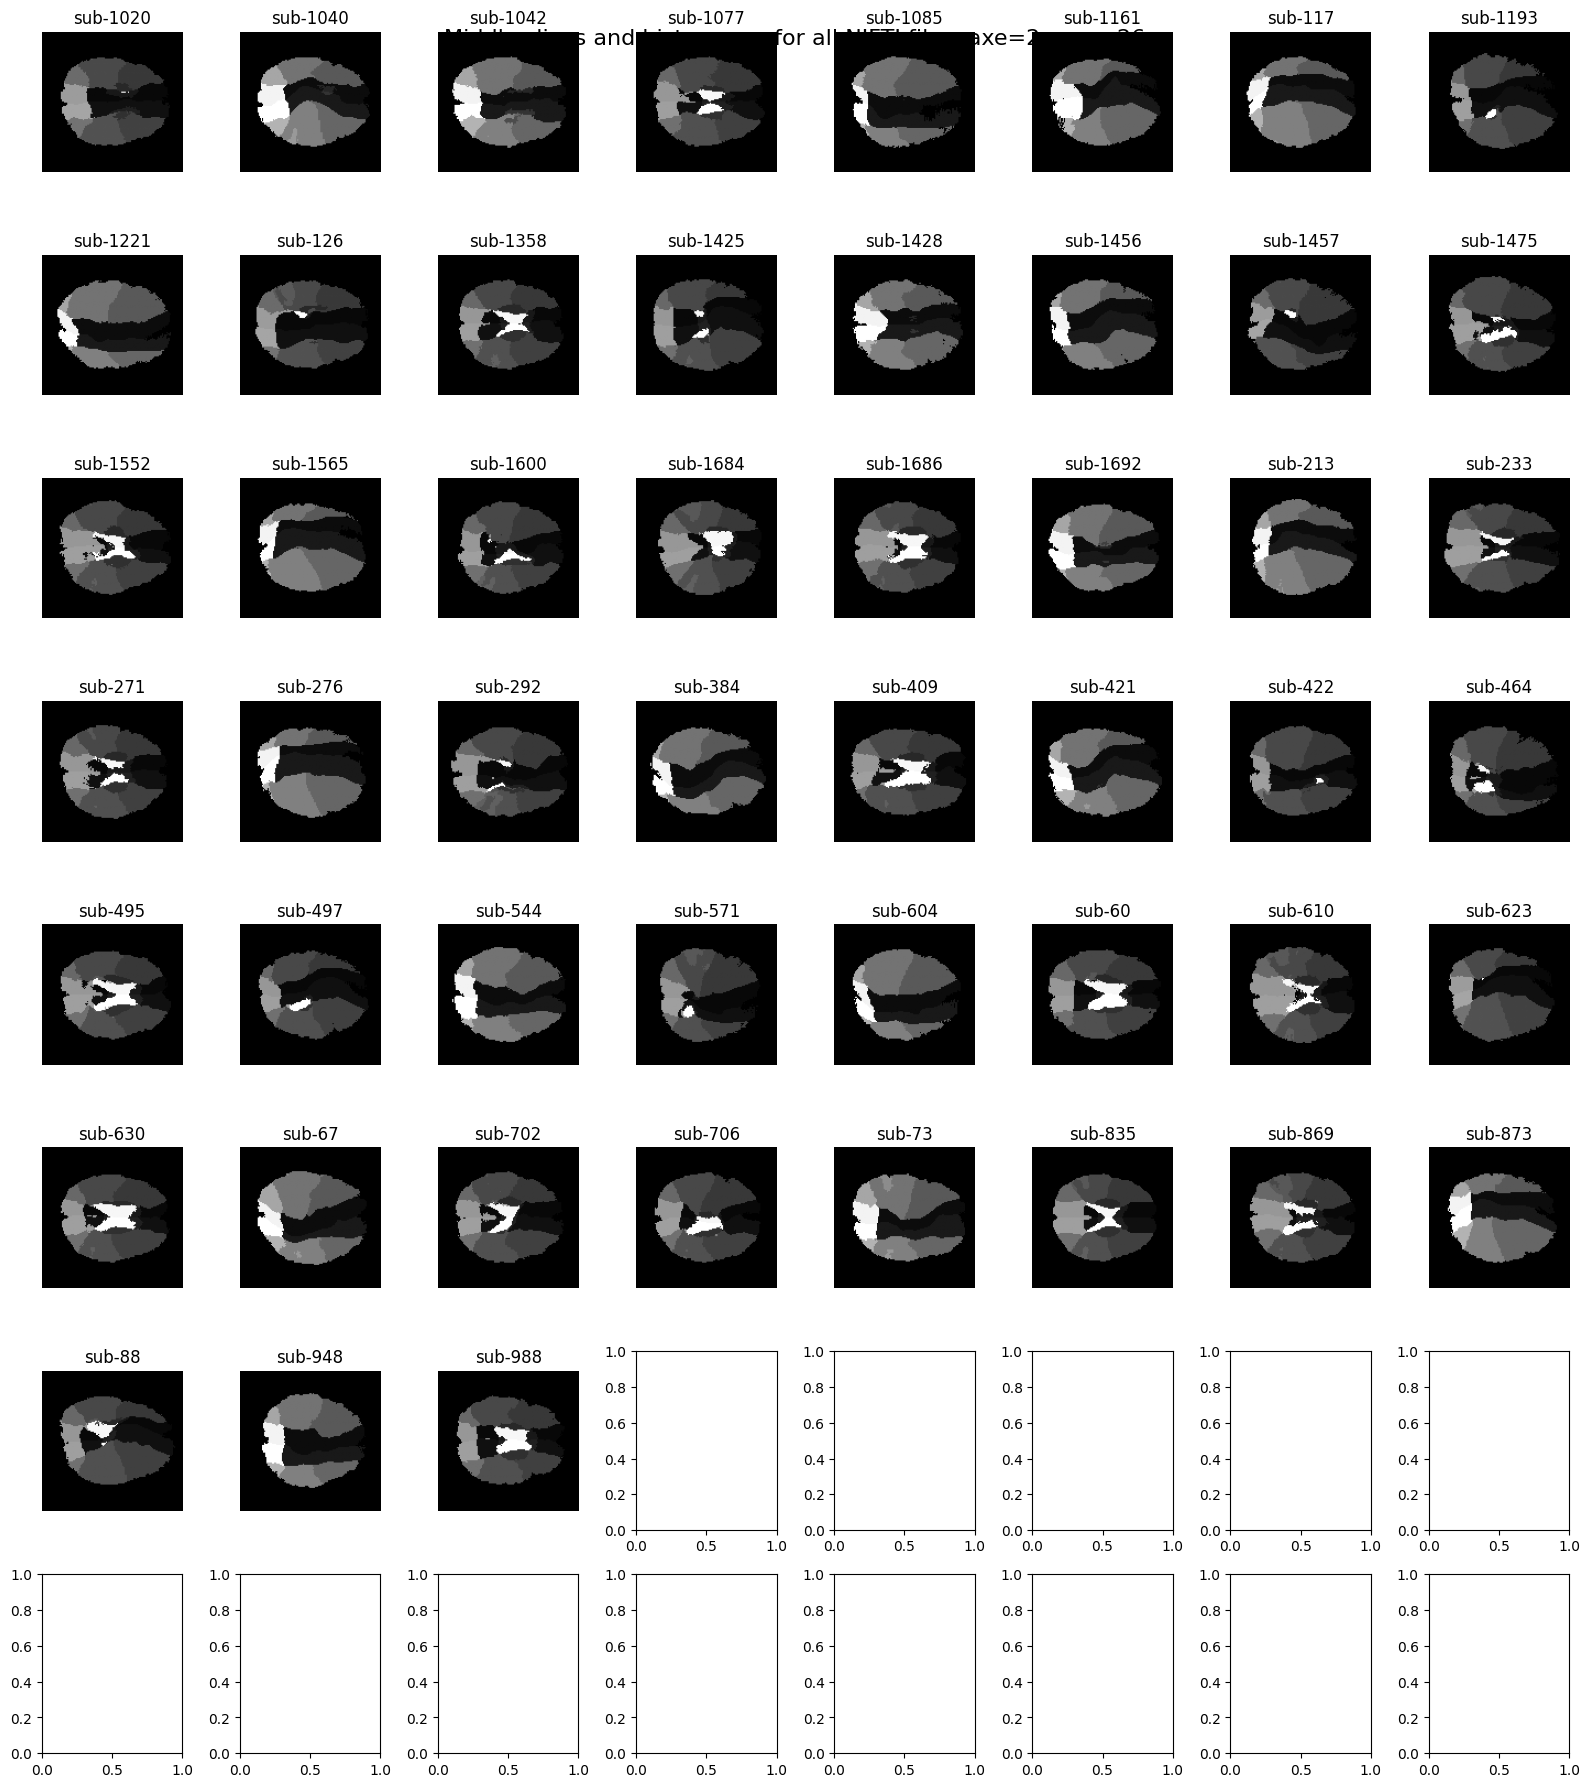

In [55]:
display_middle_slice(registered_atlases_folder, axe=2, nb_images=64, page_number=26, figsize=16, normalize_from_histogram_peak=False, hist_norm_target_value=200, max_display_value=30)